In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture
import test_utils
import os
import sys

In [36]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('fashion-mnist', 128, False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [38]:
n_layers=10
model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=128*1*1,
    dec_hidden_dim=(128,1,1),
    input_dim=1*28*28,
    latent_dim=10,
    encoder_name='omniglot',
    decoder_name='omniglot',
    kl1_weight=1
).to(device)
path = '/nethome/zwang910/file_storage/nips-2025/deep-taxon/project-checkin/'
# run = 'vade-10-rec-10-reg-1.2-cifar/'
run = 'vade-10-rec-5-reg-1.2-fmnist/'
# run = 'vade-11-reg-1-fmnist/'
checkpoint = 'deep_taxon_280.pt'
model.load_state_dict(torch.load(f'{path}{run}{checkpoint}'))

<All keys matched successfully>

In [29]:
annotation = utils.label_annotation(model, train_loader, 10, device)
acc = utils.basic_node_evaluation(model, annotation, test_loader, device)
print('acc:', acc)

acc: 0.4288


In [17]:
dendrogram_purity = utils.compute_dendrogram_purity(model, test_loader, annotation, device)
print('dendrogram_purity:', dendrogram_purity)

dendrogram_purity: 0.10398774823362616


In [39]:
dendrogram_purity = test_utils.compute_soft_dendrogram_purity_test_only(model, test_loader, device)
print('dendrogram_purity:', dendrogram_purity)

Processing test data to get probability distributions (pcx)...


Evaluating Test Set: 100%|██████████| 40/40 [00:01<00:00, 21.84it/s]


Processed 10000 test samples. Found 10 classes and 2047 nodes.
Calculating node purities based on test set expected counts...
Node purities calculated.
Calculating Soft Dendrogram Purity (iterating over pairs)...


Processing Classes: 100%|██████████| 10/10 [07:59<00:00, 47.98s/it]

Calculation complete.
dendrogram_purity: 0.6167082260712516


In [40]:
overall_leaf_purity, per_leaf_purities = utils.compute_leaf_purity(model, test_loader, device)
print('overall_leaf_purity:', overall_leaf_purity)
print('per_leaf_purities:', per_leaf_purities)

overall_leaf_purity: 0.8231987092223002
per_leaf_purities: {0: (0.6359920726636731, 1.5872981225024254), 1: (0.6317036023522133, 2.8059586161639283), 2: (0.9999740074923239, 8.099182762385055), 3: (0.9999999986809572, 8.667099029056224), 4: (0.7585972433982828, 4.01482337388674), 5: (0.5592874261214941, 5.265802571773249), 6: (0.7424438334401076, 2.4655320508363014), 7: (0.47055860697313767, 1.8444374236739862), 8: (0.9571660202529276, 5.909256754932587), 9: (0.7328355506594745, 8.303666567209966), 10: (0.8033865286366191, 6.428504915969903), 11: (0.4223712218527423, 5.195457226838208), 12: (0.6875316787545459, 4.68384601727734), 13: (0.795217745393234, 7.271334832141424), 14: (0.5205225338774863, 3.970943525541906), 15: (0.8337953999911526, 7.318100871609492), 16: (0.5797231021122199, 1.9121550748380822), 17: (0.5133208482073255, 3.5512397768429023), 18: (0.9954028630039613, 4.738190919742339), 19: (0.8682790131038614, 4.622406934367384), 20: (0.548532291939444, 2.299295943160373), 21

## Few-shot testing

In [79]:
utils.testing_few_shot(model, test_loader, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]

Few-shot accuracy: 0.5509


0.5508533333333333

,u_c.shape: torch.Size([2047, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.084933..1.0075763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.110151656..1.0240474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15248829..1.011448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10761385..1.012883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.076446034..1.0463854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2171846..1.0289873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19814123..

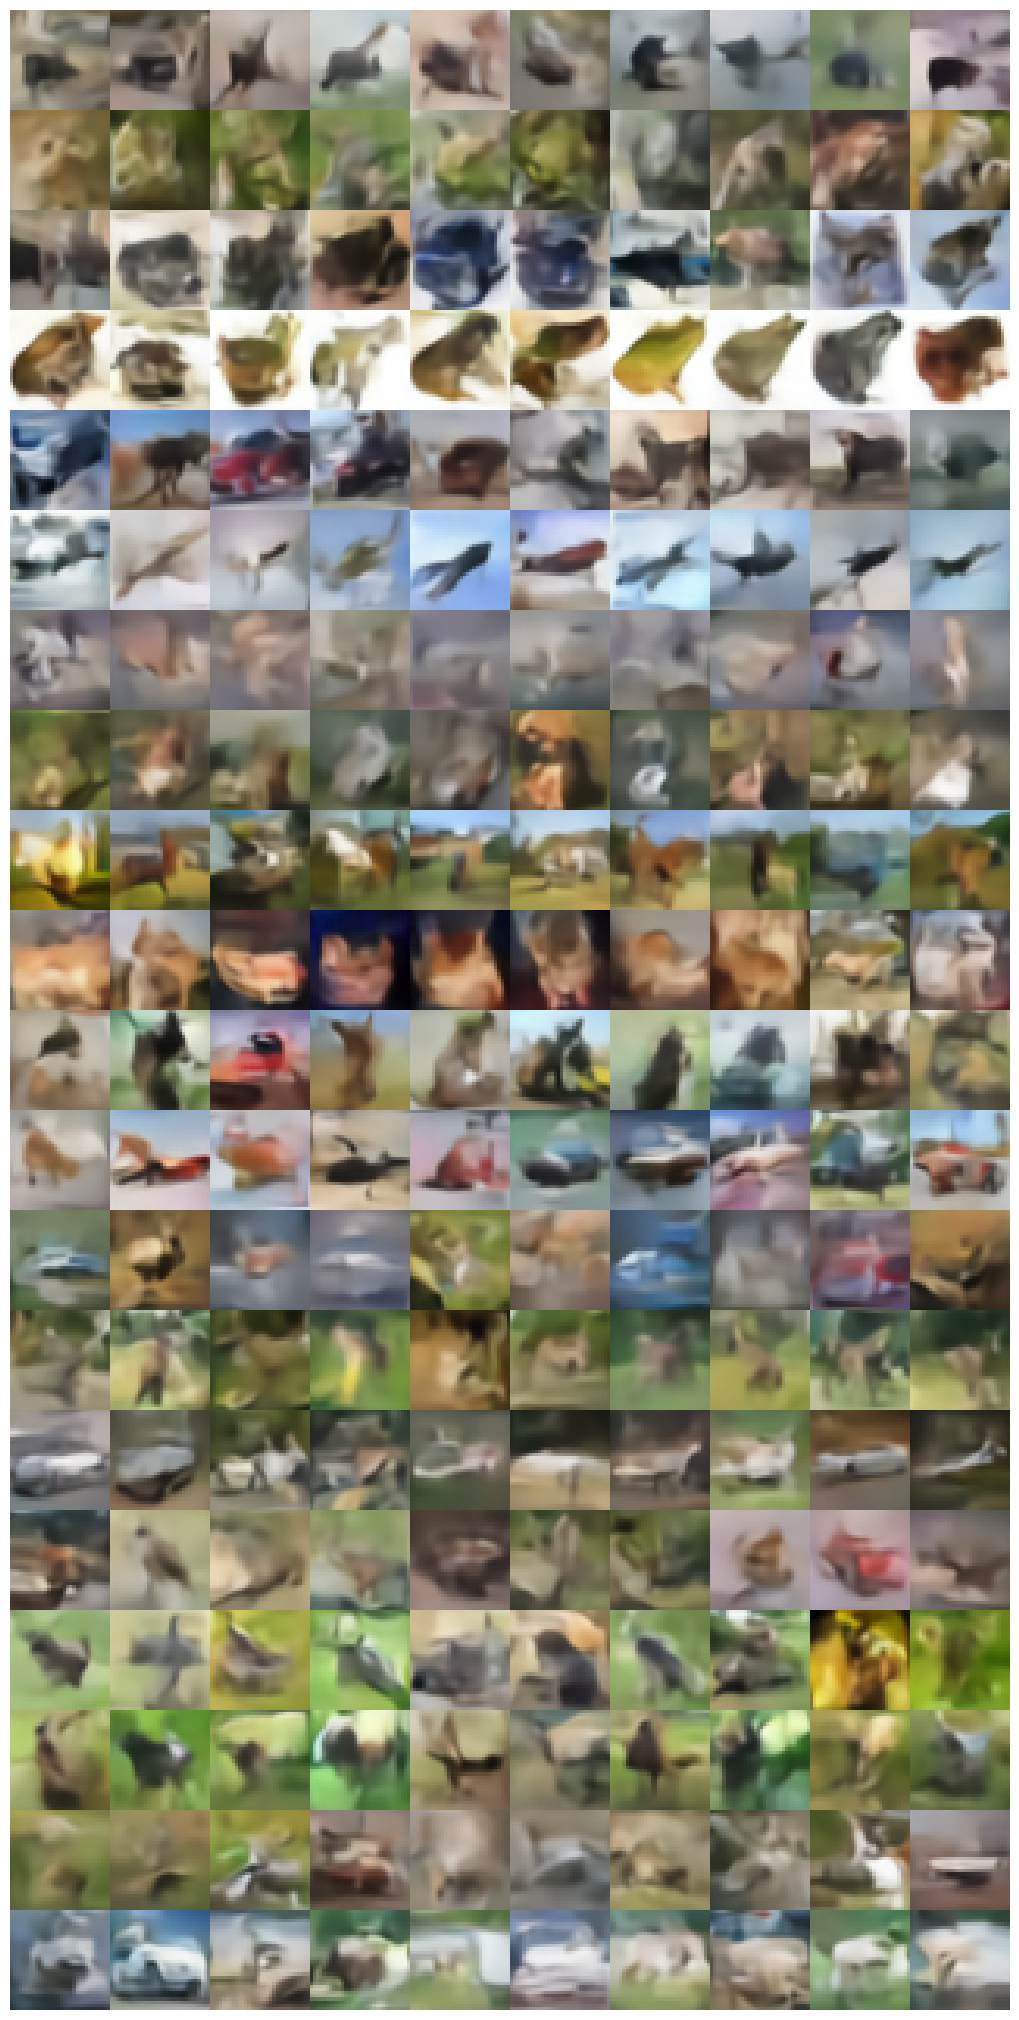

In [45]:
offset = 60
layer = 10
n_examples = 10
subset_len = 20

pi, mu_c, logvar_c, H, alphas, dkl_list = model.gmm_params()
print(',u_c.shape:', mu_c.shape)

mu_c = mu_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, mu_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)
logvar_c = logvar_c[offset:offset+subset_len, :].unsqueeze(1).expand(-1, n_examples, -1).reshape(-1, logvar_c.shape[-1]) # shape: (n_clusters * n_examples, n_hidden)

# print(f"mu_c shape: {mu_c.shape}")
# break

eps = torch.randn_like(mu_c)  # shape: (n_clusters * n_examples, n_hidden) 
# make the noise smaller
eps = eps
z = mu_c + torch.exp(logvar_c / 2) * eps  # shape: (n_clusters * n_examples, n_hidden)
x = model.decode(z.to(device))  # shape: (n_clusters * n_examples, C, H, W)
x = x.view(-1, n_examples, *x.shape[1:]).detach().cpu().numpy()  # shape: (n_clusters, n_examples, C, H, W)

n_clusters = x.shape[0]

# generate small noise for each cluster for each example
# Create subplots: n_clusters rows and n_examples columns.
fig, axes = plt.subplots(n_clusters, n_examples, figsize=(n_examples, n_clusters))
# Force the axes array to be 2D.
if n_clusters == 1 and n_examples == 1:
    axes = np.array([[axes]])
elif n_clusters == 1:
    axes = np.expand_dims(axes, axis=0)
elif n_examples == 1:
    axes = np.expand_dims(axes, axis=1)
    
# Loop over clusters and examples to display each generated image.
for i in range(n_clusters):
    for j in range(n_examples):
        ax = axes[i, j]
        img = x[i, j]
        # If the image is grayscale (1 channel), remove the extra dimension.
        if img.shape[0] == 1:
            img = img.squeeze(0)
            ax.imshow(img, cmap='gray')
        else:
            # For color images, convert from (C, H, W) to (H, W, C)
            # img = np.transpose(img, (1, 2, 0))
            # print(f"img shape: {img.shape}")
            # print(f"img shape: {img.shape}")
            ax.imshow(img.transpose(1, 2, 0))
        ax.axis("off")  # Remove axis ticks and labels

# Remove spacing between subplots.
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
# return fig
plt.show()